# Project :- Bike Sharing Analysis with Ford GoBike Data


 

In [1]:
# Import all packages and set plots to be embedded inline
from requests import get
from os import path, getcwd, makedirs, listdir 
from io import BytesIO
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
import datetime
import math
import calendar
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Download the dataset 
folder_name_of_csvs = 'Data_files'

makedirs(folder_name_of_csvs)
pd.read_csv('https://s3.amazonaws.com/fordgobike-data/2017-fordgobike-tripdata.csv').to_csv('{}/2017-forgobike-tripdata.csv'.format(folder_name_of_csvs))
for month in range(1,12):
    month_string = str(month)
    month_leading_zero = month_string.zfill(2)
    
    bike_data_url = 'https://s3.amazonaws.com/fordgobike-data/2018' + month_leading_zero + '-fordgobike-tripdata.csv.zip'
    response = get(bike_data_url)
        
    # Code below opens zip file; BytesIO returns a readable and writable view of the contents
    unzipped_file = ZipFile(BytesIO(response.content))
        
    # Extracted the zip file into folder trip_data_files
    unzipped_file.extractall(folder_name_of_csvs)

In [3]:
# Merge all locally saved CSVs into One gobike
all_files = []
for file_name in listdir(folder_name_of_csvs):
    all_files.append(pd.read_csv(folder_name_of_csvs+'/'+file_name))
gobike = pd.concat(all_files)

In [4]:
# Save gobike to data.csv
gobike.to_csv('mergeData.csv')

In [5]:
# examine gobike
gobike = pd.read_csv('mergeData.csv')

Text(0.5, 0, 'Age bike riders')

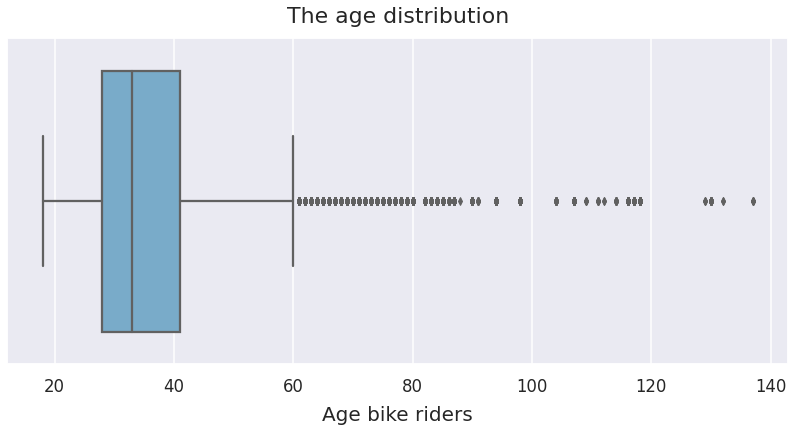

In [7]:
# Set visualization style
sns.set_style('darkgrid')
sns.set_context("talk")

# Filter data to include reasonable member age range
gobike['member_age'] = 2018-gobike['member_birth_year']

plt.figure(figsize=(14,6))
sns.boxplot(x='member_age', data=gobike, palette='Blues_r', orient='h')
plt.title("The age distribution", fontsize=22, y=1.03)
plt.xlabel("Age bike riders", fontsize=20, labelpad=10)

In [8]:
gobike = gobike[gobike['member_age']<=60]

In [9]:
gobike['member_age'].mean()

34.783988359178586

In [10]:
# Filter data only to include Ashby BART 
max_longitude_ab = -122.3597
min_longitude_ab = -122.5147
max_latitude_ab = 37.8121
min_latitude_ab = 37.7092

In [11]:
end_station_latitude_mask = (gobike['end_station_latitude']>=min_latitude_ab) & (gobike['end_station_latitude']<=max_latitude_ab)
start_station_latitude_mask = (gobike['start_station_latitude']>=min_latitude_ab) & (gobike['start_station_latitude']<=max_latitude_ab)

end_station_longitude_mask =(gobike['end_station_longitude']>=min_longitude_ab) & (gobike['end_station_longitude']<=max_longitude_ab)
start_station_longitude_mask = (gobike['start_station_longitude']>=min_longitude_ab) & (gobike['start_station_longitude']<=max_longitude_ab)

In [12]:
gobike = gobike[end_station_latitude_mask & start_station_latitude_mask & end_station_longitude_mask & start_station_longitude_mask]



### What is/are the main feature(s) of interest in your dataset?

> There is many like:  
- Gender  
- Average riding duration  
- Average riding distance  
- Age groups of users 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I think that the age group, gender, duration of use and purpose of use are the most important data to focus on.

## Univariate Exploration

In [13]:
# Create new fields for date from start_time and end_time
gobike['start_time'] = pd.to_datetime(gobike['start_time'])
gobike['end_time'] = pd.to_datetime(gobike['end_time'])

gobike['start_time_date'] = gobike['start_time'].dt.date
gobike['end_time_date'] = gobike['end_time'].dt.date

gobike['start_time_year_month'] = gobike['start_time'].map(lambda x: x.strftime('%Y-%m'))
gobike['end_time_year_month'] = gobike['end_time'].map(lambda x: x.strftime('%Y-%m'))

gobike['start_time_year_month_renamed'] = gobike['start_time'].dt.strftime('%y' + '-' + '%m')

gobike['start_time_year'] = gobike['start_time'].dt.year.astype(int)
gobike['end_time_year'] = gobike['end_time'].dt.year.astype(int)

gobike['start_time_month'] = gobike['start_time'].dt.month.astype(int)
gobike['end_time_month'] = gobike['end_time'].dt.month.astype(int)

gobike['start_time_hour_minute'] = gobike['start_time'].map(lambda x: x.strftime('%H-%m'))
gobike['end_time_hour_minute'] = gobike['end_time'].map(lambda x: x.strftime('%H-%m'))

gobike['start_time_hour'] = gobike['start_time'].dt.hour
gobike['end_time_hour'] = gobike['end_time'].dt.hour

gobike['start_time_weekday_abbr'] = gobike['start_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])
gobike['end_time_weekday_abbr'] = gobike['end_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])

# Create a new field for member age group from member_age_bin
gobike['member_age_bins'] = gobike['member_age'].apply(lambda x: '10 - 20' if 10<x<=20
                                                  else '20 - 30' if 20<x<=30
                                                  else '30 - 40' if 30<x<=40
                                                  else '40 - 50' if 40<x<=50
                                                  else '50 - 60' if 50<x<=60
                                                  else x)

# Create minutes for trip duration from duration_sec
gobike['duration_min'] = gobike['duration_sec']/60

# Create new fields for distance
def distance(origin, destination):
    firstLat, firstlon = origin
    secondistanceLat, secondistanceLon = destination
    radiusValue = 6371

    distanceLat = math.radians(secondistanceLat - firstLat)
    distanceLon = math.radians(secondistanceLon - firstlon)
    firstValue = (math.sin(distanceLat / 2) * math.sin(distanceLat / 2) +
         math.cos(math.radians(firstLat)) * math.cos(math.radians(secondistanceLat)) *
         math.sin(distanceLon / 2) * math.sin(distanceLon / 2))
    secondValue = 2 * math.atan2(math.sqrt(firstValue), math.sqrt(1 - firstValue))
    result = radiusValue * secondValue

    return result
	
gobike['distance_km_estimates'] = gobike.apply(lambda x: distance((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])), axis=1)
gobike['distance_miles_estimates'] = gobike['distance_km_estimates']*0.621371

### Average count of rides 


In [14]:
count_rides = gobike.groupby('start_time_year_month_renamed')['bike_id'].size().reset_index()
count_unique_rides = gobike.groupby('start_time_year_month_renamed')['bike_id'].nunique().reset_index().rename(columns={'bike_id':'unique_bike_id'})
count_rides_dataFrame = count_rides.merge(count_unique_rides, on='start_time_year_month_renamed')
count_rides_dataFrame['number_of_used'] = count_rides_dataFrame['bike_id']/count_rides_dataFrame['unique_bike_id']
Oct_2017_AVG_BikeUsed = (count_rides_dataFrame[count_rides_dataFrame['start_time_year_month_renamed']=='17-10']['number_of_used'].mean())/31
Oct_2018_AVG_BikeUsed = (count_rides_dataFrame[count_rides_dataFrame['start_time_year_month_renamed']=='18-10']['number_of_used'].mean())/31


In [15]:
print(Oct_2017_AVG_BikeUsed, Oct_2018_AVG_BikeUsed)

1.5166275470992667 2.8942722061838415


In [16]:
print(Oct_2018_AVG_BikeUsed/Oct_2017_AVG_BikeUsed)

1.9083605673123152


In [17]:
def transform_axis(dailyBike, pos):
    if dailyBike >= 1000:
        value = int(dailyBike/1000)
        return '{:d}K'.format(value)
    elif dailyBike >= 1000000: 
        value = int(dailyBike/1000000)
        return '{:d}M'.format(value)
    else:
        return int(dailyBike)

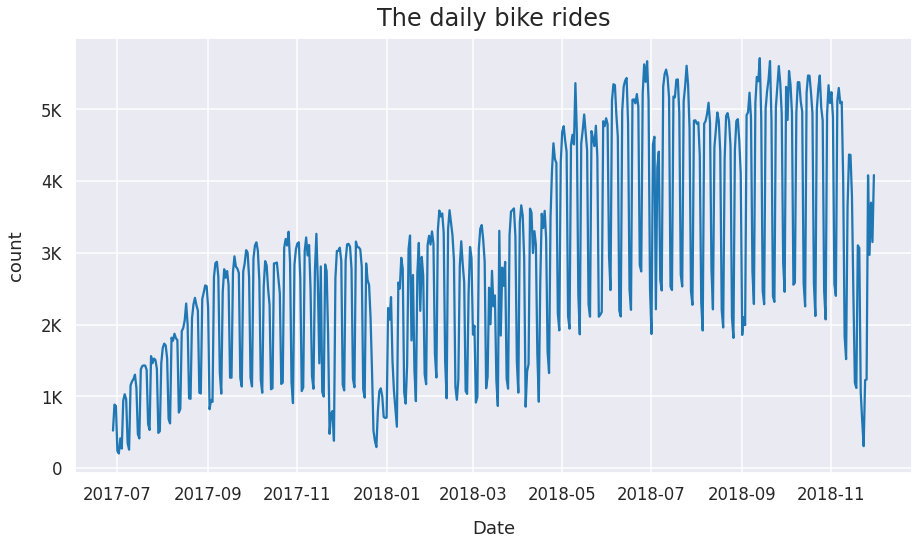

In [18]:
gobike.groupby('start_time_date').agg({'bike_id':'count'}).plot(style='-', legend=False, figsize=(15,8))
plt.title('The daily bike rides', fontsize=24, y=1.015)
plt.xlabel('Date', labelpad=16)
plt.ylabel('count', labelpad=16)
axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis))

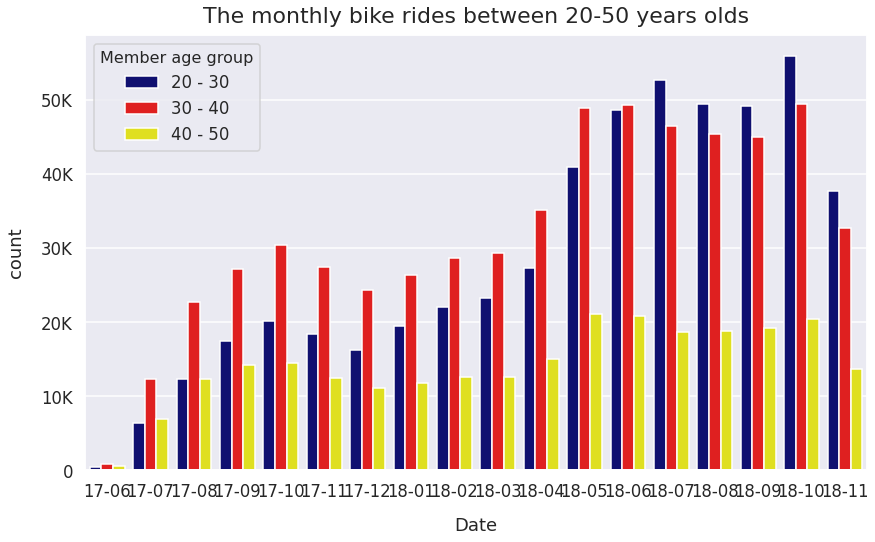

In [19]:
plt.figure(figsize=(14,8))
palette = {'20 - 30': 'navy', '30 - 40': 'red', '40 - 50': 'yellow'}
axis = sns.countplot(x='start_time_year_month_renamed', hue='member_age_bins', palette=palette, data=gobike[gobike['member_age_bins'].isin(['20 - 30', '30 - 40', '40 - 50'])].sort_values(by=['start_time_year_month_renamed', 'member_age_bins']))
plt.title('The monthly bike rides between 20-50 years olds', fontsize=22, y=1.015)
plt.xlabel('Date', labelpad=16)
plt.ylabel('count', labelpad=16)
leg = axis.legend()
leg.set_title('Member age group',prop={'size':16})
axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis))

> 20-30 years old users are rapidly growing compared to other user groups. When the service first started 30-40 years old users were dominant, however 20-30 years old users became a leader in a year.

(0.0, 100.0)

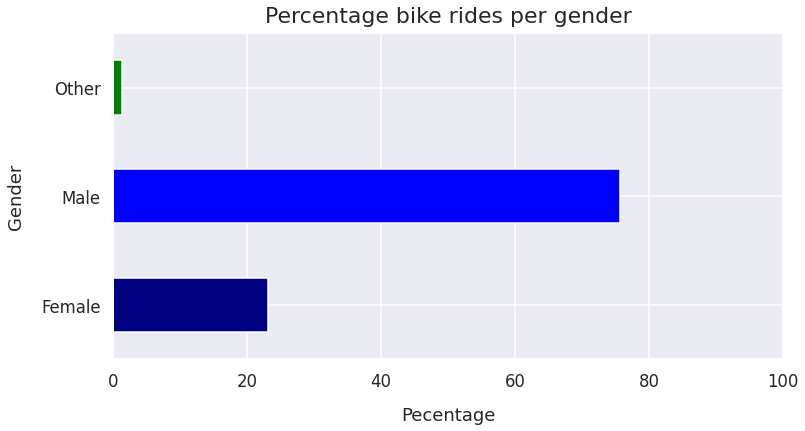

In [20]:
gender_trips = gobike.groupby('member_gender').agg({'bike_id':'count'})
gender_trips['perc'] = (gender_trips['bike_id']/gender_trips['bike_id'].sum())*100

colors = ['navy', 'blue', 'green']
gender_trips['perc'].plot(kind='barh', color=colors, figsize=(12,6))
plt.title('Percentage bike rides per gender', fontsize=22, y=1.015)
plt.ylabel('Gender', labelpad=16)
plt.xlabel('Pecentage', labelpad=16)
plt.xticks(rotation=360)
plt.xlim(0,100)

> Male took around %75 of all bike rides, and female took around %22 of them.

### Bike rides per weekday

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

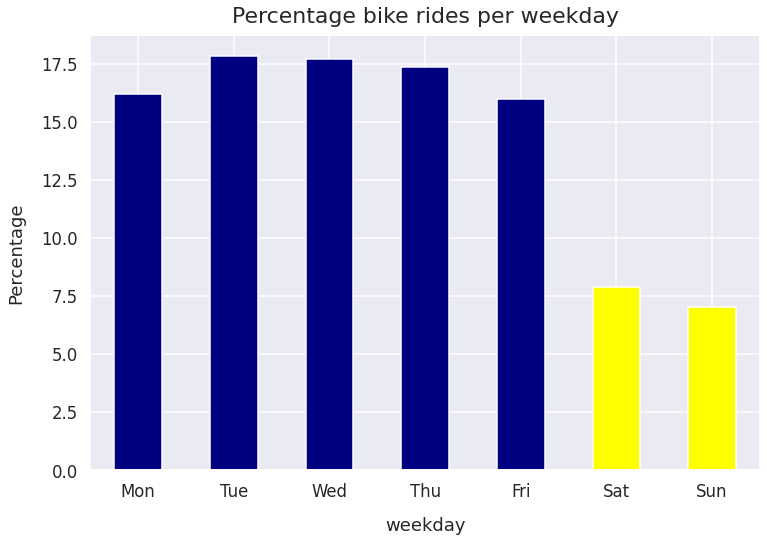

In [22]:
weekday_trips = gobike.groupby('start_time_weekday_abbr').agg({'bike_id':'count'})
weekday_trips['perc'] = (weekday_trips['bike_id']/weekday_trips['bike_id'].sum())*100
weekday_index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

colors = ['navy', 'navy', 'navy', 'navy', 'navy', 'yellow', 'yellow']
weekday_trips.reindex(weekday_index)['perc'].plot(kind='bar', color=colors, figsize=(12,8), legend=False)
plt.title('Percentage bike rides per weekday', fontsize=22, y=1.015)
plt.xlabel('weekday', labelpad=16)
plt.ylabel('Percentage', labelpad=16)
plt.xticks(rotation=360)


> People use this service on weekdays more than weekends.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> made some calculations to prepare the data to be placed in the graphs because the data is not ready to be used directly.
After viewing the graphs we draw the following observations:
- 20-30 years old users are rapidly growing compared to other user groups.
- 20 to 40 years old people took the more than %70 of bike rides.
- Among those, 30 to 40 years old people's rides account almost %40 of all bike rides.
- Male took around %76 of all bike rides, and female took around %24 of them.
- People use this service on weekdays more than weekends.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> I will summarize the work as points:
- At the beginning I conducted a filter on the ages of members and through the graph I concluded that the age range starts from 18 years to less than 140 years, but the vast majority, which represents about 95% is between 18 years to 60 years, so I focused on this range for a number of reasons, the data provide a lot, which represents 95% and also to exclude extreme values.
- I have created new fields such as (timing - age groups - duration) to facilitate the conduct of mathematical calculations and understand the data in a better way.
- The service is spread in more than one city such as (Oakland - San Jose - San Carlos), which makes it difficult to represent data traffic in all cities, and to simplify the matter chose the city of San Carlos by determining the coordinates of the city by looking at the data and the use of some sites on the Internet.

## Bivariate Exploration

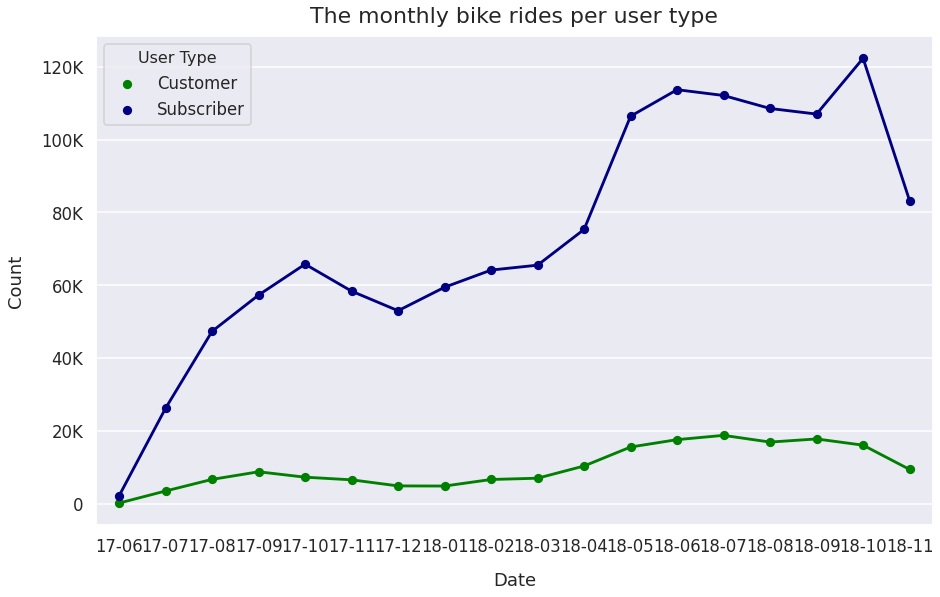

In [23]:
user_type_count = gobike.groupby(["start_time_year_month_renamed", "user_type"]).size().reset_index()

plt.figure(figsize=(15,9))
palette = {'Subscriber':'navy', 'Customer':'green'}
axis = sns.pointplot(x='start_time_year_month_renamed', y=0, hue='user_type', palette=palette, scale=.7, data=user_type_count)
plt.title('The monthly bike rides per user type', fontsize=22, y=1.015)
plt.xlabel('Date', labelpad=16)
plt.ylabel('Count', labelpad=16)
leg = axis.legend()
leg.set_title('User Type',prop={'size':16})
axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis))


### Average trip duration of subscribers vs customers

Text(0.5, 0, 'trip duration in minutes')

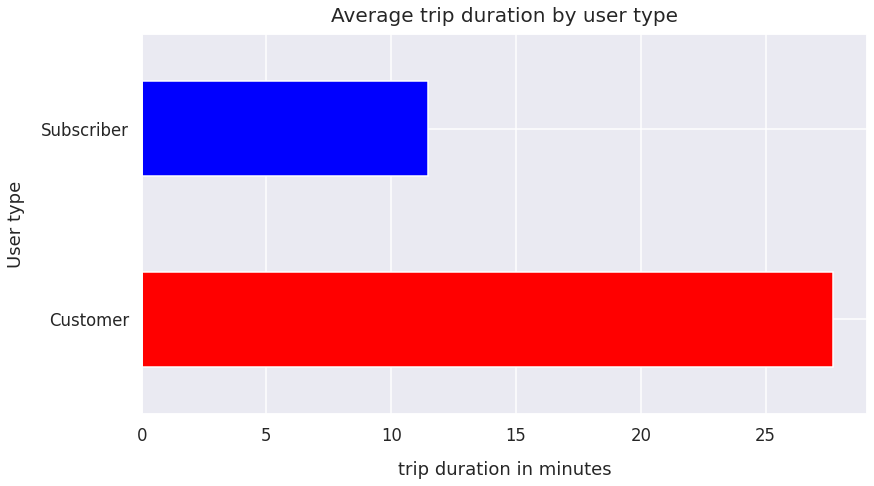

In [24]:
colors=['red', 'blue']
axis = gobike.groupby('user_type')['duration_min'].mean().plot(kind='barh', color=colors, figsize=(13,7))
axis.set_title('Average trip duration by user type', fontsize=20, y=1.015)
axis.set_ylabel('User type', labelpad=16)
axis.set_xlabel('trip duration in minutes', labelpad=16)

**Subscribers' average trip duration is ~ 11 minutes.**

**Customers' average trip duration is ~ 28 minutes.**

### The trend of subscribers' bike rides per age group

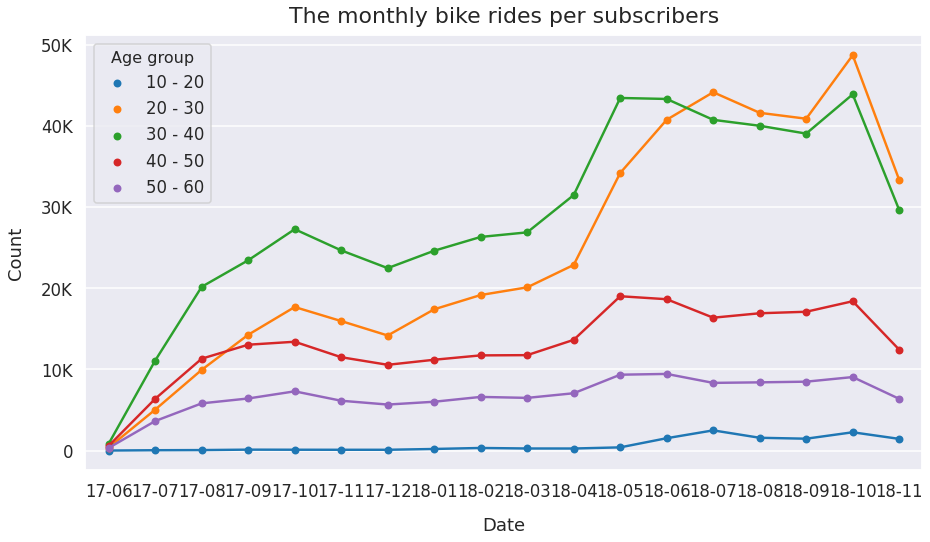

In [25]:
subscriber_age = gobike[gobike['user_type']=='Subscriber'].groupby(['start_time_year_month_renamed', 'member_age_bins']).agg({'bike_id':'count'}).reset_index()

plt.figure(figsize=(15,8))
axis = sns.pointplot(x='start_time_year_month_renamed', y='bike_id', hue='member_age_bins', scale=.6, data=subscriber_age)
plt.title("The monthly bike rides per subscribers", fontsize=22, y=1.015)
plt.xlabel('Date', labelpad=16)
plt.ylabel('Count', labelpad=16)
leg = axis.legend()
leg.set_title('Age group',prop={'size':16})
axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis))


**we can see from the chart of the participants there is a convergence between the age groups (20-30) and (30-40), the same applies to the age categories (40-50) and (50-60), while the category (10-20) is considered Least among the age groups.**

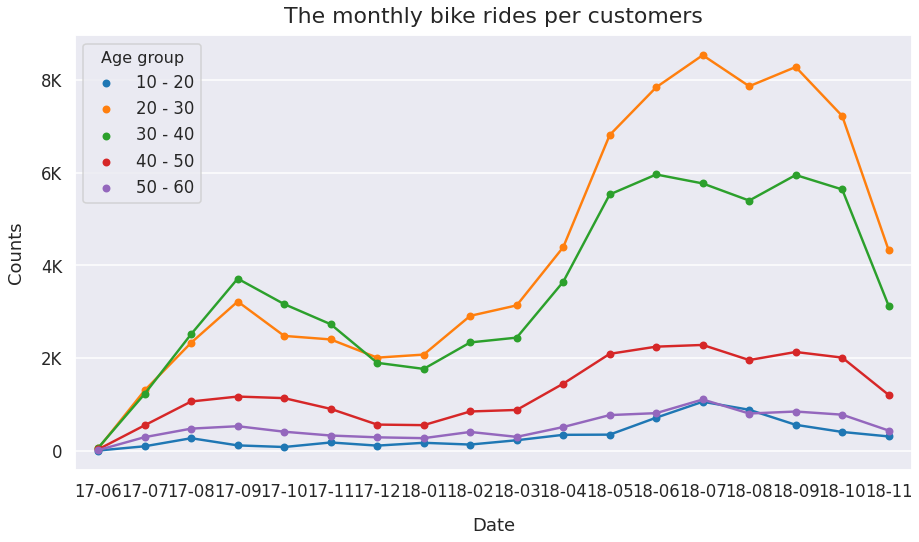

In [26]:
customer_age = gobike[gobike['user_type']=='Customer'].groupby(['start_time_year_month_renamed', 'member_age_bins']).agg({'bike_id':'count'}).reset_index()

plt.figure(figsize=(15,8))
axis = sns.pointplot(x='start_time_year_month_renamed', y='bike_id', hue='member_age_bins', scale=.6, data=customer_age)
plt.title("The monthly bike rides per customers", fontsize=22, y=1.015)
plt.xlabel('Date', labelpad=16)
plt.ylabel('Counts', labelpad=16)
legs = axis.legend()
legs.set_title('Age group',prop={'size':16})
axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis))


**we can see from the chart of the participants there is a convergence between the age groups (20-30) and (30-40), but the age categories (40-50) is less than previous categories, while the category (10-20) and (50-60)  is considered Least among the age groups.**


**Electric bike rides vs regular bike ride for the first month.**

In [29]:
gobike['electric_bike'] = gobike['bike_id'].isin(electric_bike)
(gobike['electric_bike'].value_counts()/gobike['electric_bike'].value_counts().sum())*100

False    91.923758
True      8.076242
Name: electric_bike, dtype: float64

> 
- 91.9% of rides are non-electric bike rides.
- 8.1% of rides are electric bike rides.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Percentage of subscribers is almost %88.15. Percentage of customers is almost %11.85.
Customers' rides seem increasing slightly. There is a decrease in November 2018 for subscribers but it seems like it is related with the winter season.
Subscribers' average trip duration is around 11 minutes. Customers' average trip duration is around 28 minutes.
Subscribers and customers trip distance was about the same, which is slightly more than one mile.
I selected the most popular group 20-40 years old people in order to compare hiring days, time of the day, peak times, etc.
Subscribers are most frequently used this service around 7-9 am and 4-6 pm. Customers have used this service at the weekend around (10 am - 5 pm) and weekday 5pm6pm. Customers use this service during the weekend for leisure and weekdays after work.
On the other hand, I checked the electrical bike program. Ford GoBike announced the launch of electric bikes as April 24th, 2018. 91.9% of rides are non-electric bike rides. Electric bike rides account for 8.1% of the total rides in the first month. It was increased suddenly at the beginning of the program launch. There is a huge spike at the end of April. After that, it seems the usage trend for electric bikes is decreasing.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> I observed that at the beginning of the electrical bike hiring program launch there was a high demand for this program. But after a while, it was decreased suddenly. Customers and subscribers may be more comfortable to drive a normal or random bike rather than an electrical and advanced technological bike.

## Multivariate Exploration


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text major ticklabel objects>)

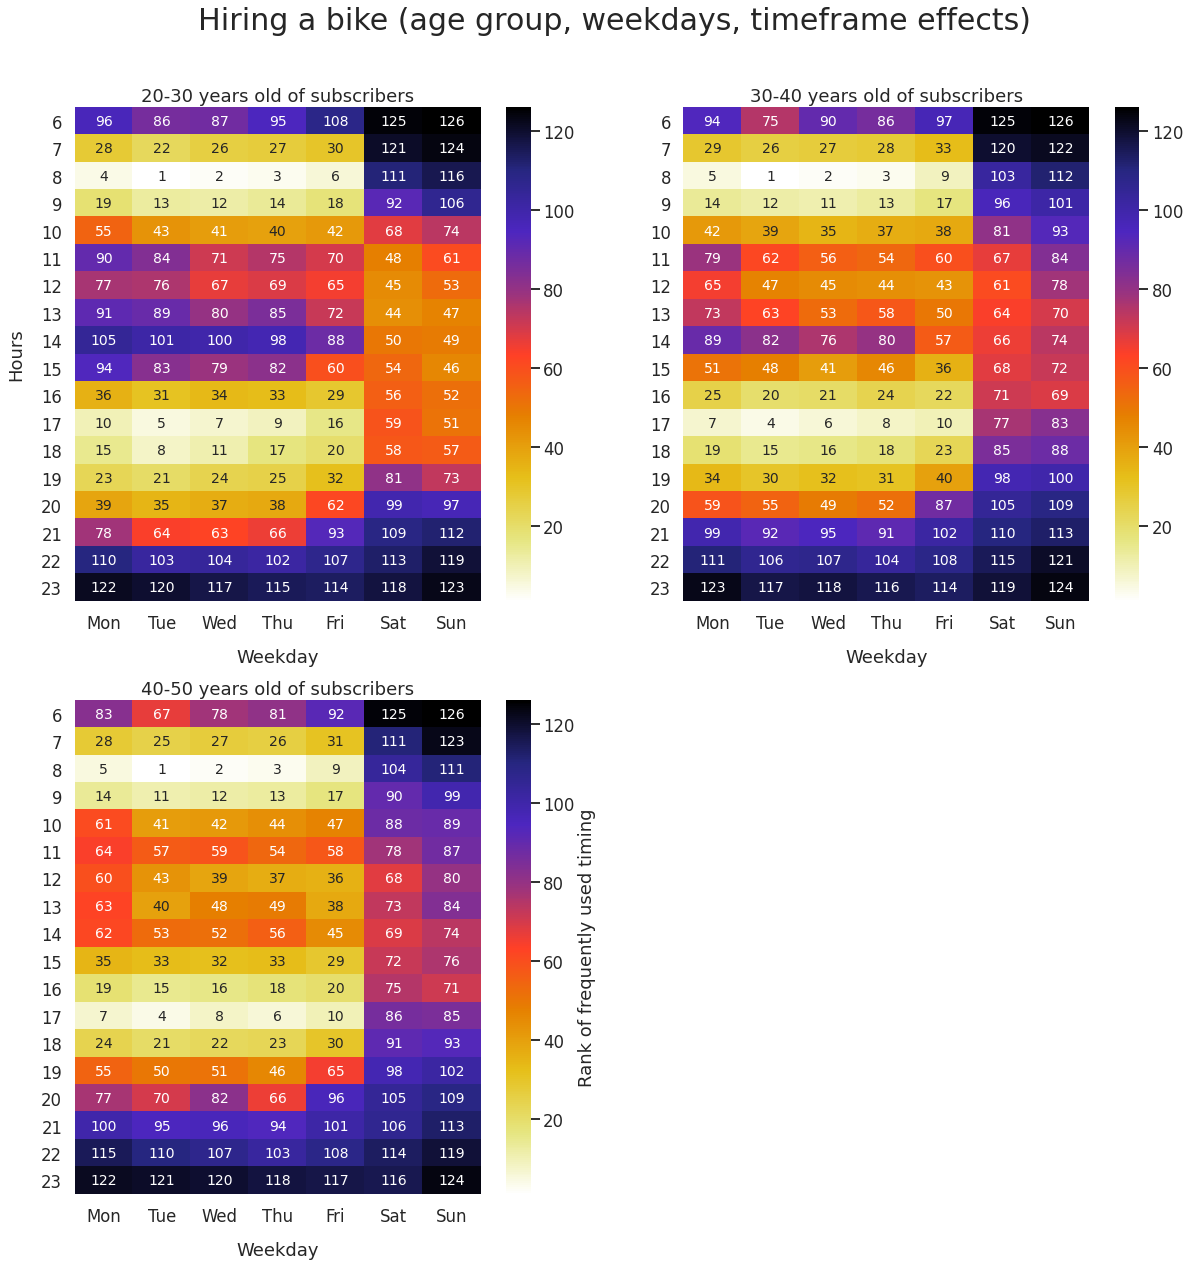

In [31]:
subscriber_hour_dataFrame = gobike[(gobike['member_age']>=20) & (gobike['member_age']<40) 
                              &(gobike['start_time_hour']>5)&(gobike['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
subscriber_hour_2 = gobike[(gobike['member_age']>=20) & (gobike['member_age']<30) 
                              &(gobike['start_time_hour']>5)&(gobike['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

subscriber_hour_3 = gobike[(gobike['member_age']>=30) & (gobike['member_age']<40) 
                              &(gobike['start_time_hour']>5)&(gobike['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

subscriber_hour_4 = gobike[(gobike['member_age']>=40) & (gobike['member_age']<50) 
                              &(gobike['start_time_hour']>5)&(gobike['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

subscriber_hour_2['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_2['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

subscriber_hour_3['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_3['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

subscriber_hour_4['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_4['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

subscriber_hour_2['count_perc'] = subscriber_hour_2['count'].apply(lambda x: (x/subscriber_hour_dataFrame['count'].sum())*100)

subscriber_hour_3['count_perc'] = subscriber_hour_3['count'].apply(lambda x: (x/subscriber_hour_dataFrame['count'].sum())*100)

subscriber_hour_4['count_perc'] = subscriber_hour_4['count'].apply(lambda x: (x/subscriber_hour_dataFrame['count'].sum())*100)

subscriber_hour_2['rank'] = subscriber_hour_2['count_perc'].rank(ascending=False).astype(int)

subscriber_hour_3['rank'] = subscriber_hour_3['count_perc'].rank(ascending=False).astype(int)

subscriber_hour_4['rank'] = subscriber_hour_4['count_perc'].rank(ascending=False).astype(int)

subscriber_hour_dataFrame_pivoted2 = subscriber_hour_2.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')

subscriber_hour_dataFrame_pivoted3 = subscriber_hour_3.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')

subscriber_hour_dataFrame_pivoted4 = subscriber_hour_4.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')


plt.figure(figsize=(20,20))
plt.subplot(221)
plt.suptitle('Hiring a bike (age group, weekdays, timeframe effects)', fontsize=30, y=0.95)
sns.heatmap(subscriber_hour_dataFrame_pivoted2, fmt='d', annot=True, cmap='CMRmap_r', annot_kws={"size": 14})
plt.title("20-30 years old of subscribers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel('Hours', labelpad=16)
plt.yticks(rotation=360)
plt.subplot(222)
sns.heatmap(subscriber_hour_dataFrame_pivoted3, fmt='d', annot=True, cmap='CMRmap_r', annot_kws={"size": 14})
plt.title("30-40 years old of subscribers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)
plt.subplot(223)
sns.heatmap(subscriber_hour_dataFrame_pivoted4, fmt='d', annot=True, cmap='CMRmap_r', annot_kws={"size": 14}, cbar_kws={'label': 'Rank of frequently used timing'})
plt.title("40-50 years old of subscribers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)


## Summary

> 
20-30 years previous users ar speedily growing compared to alternative user teams. once the service 1st started 30-40 years previous users were dominant, but 20-30 years previous users became a frontrunner during a year.
20 to 40 years previous individuals took the quite p of motorbike rides. Among those, 30 to 40 years previous people's rides account almost of all bike rides.
Male took around %76 of all bike rides, and female took around %24 of them.
People use this service on weekdays quite weekends.
8 am and 5 pm ar the peak hours for this service. Also, individuals use this service once they are in mealtime similarly.
Percentage of subscribers is almost %88.15. Percentage of customers is almost %11.85.
there's a decrease in Nov 2018 for subscribers however it feels like it's connected with the winter season.
Subscribers' average trip length is around 11 minute. Customers' average trip length is around 28 minutes.
Subscribers and customers trip distance was regarding constant, that is slightly quite one mile.
90% of motorbike riders turn up on a weekday.
The peak bike rides time for all members is around commute time.